# Data Preparation and Create a Baseline Model

In [288]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import help_function as hf

%matplotlib inline

In [4]:
df = pd.read_csv('data/ai4i2020.csv')

In [5]:
df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


## Get the data ready

In [85]:
def col_name_cnvt(df):
    '''
    Take the columns needed,
    and remove space and units, and replace column names with lowercase.
    It does a inplace operation.
    
    Input: a dataframe
    Return: a new dataframe.
    '''
    data = df.iloc[:, 2:-5]
    col_labels = data.columns
    col_labels = [label.split(' [')[0].lower() for label in col_labels]
    col_labels = ['_'.join(label.split()) for label in col_labels]
    data.columns = col_labels
    return data

In [289]:
data = hf.col_name_cnvt(df)
data.head()

,type,air_temperature,process_temperature,rotational_speed,torque,tool_wear,machine_failure
0,M,298.1,308.6,1551,42.8,0,0
1,L,298.2,308.7,1408,46.3,3,0
2,L,298.1,308.5,1498,49.4,5,0
3,L,298.2,308.6,1433,39.5,7,0
4,L,298.2,308.7,1408,40.0,9,0


## Create a baseline model

In [95]:
X = data.drop(columns='machine_failure')
y = data.machine_failure

In [293]:
# train test split
# use stratify to enforce the proportion in the splits
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [294]:
X_train.head()

,type,air_temperature,process_temperature,rotational_speed,torque,tool_wear
6792,L,301.2,310.6,1811,24.0,84
55,L,298.8,309.1,1512,40.7,156
5562,L,302.3,311.7,1648,32.1,197
3831,M,302.3,310.9,1742,29.7,137
5311,H,303.7,312.9,1460,49.8,2


### 1. Build a Logistic Regression model using pipeline

In [303]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

proc_col_name = FunctionTransformer(hf.col_name_cnvt)
ohe = OneHotEncoder()
scaler = StandardScaler()

cat_cols = make_column_selector(dtype_exclude='number')
num_cols = make_column_selector(dtype_include='number')

preprocessor = make_column_transformer(
    (ohe, cat_cols),
    (scaler, num_cols)
)

pipe = Pipeline([
    ('prep', preprocessor),
    ('model', LogisticRegression())
])

In [304]:
pipe.fit(X_train, y_train,)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x00000230A0046310>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x00000230A02AC250>)])),
                ('model', LogisticRegression())])

### 2. Evaluate the model performance

In [140]:
# import metrics
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [297]:
y_pred = pipe.predict(X_test)

In [263]:
def evaluate(y_test, y_pred):
    '''print recall and precision, and display confusion matrix'''
    print(f'Recall: {recall_score(y_test, y_pred)}')
    print(f'Precision: {precision_score(y_test, y_pred)}')
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred);

Recall: 0.17647058823529413
Precision: 0.8571428571428571


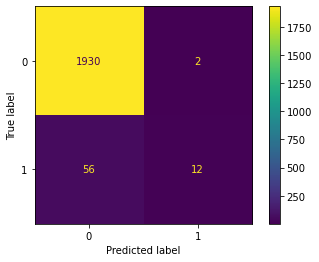

In [298]:
hf.evaluate(y_test, y_pred)

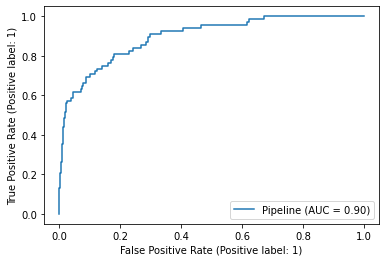

In [299]:
# Consider the best cutoff threshold
# It seems the 0.2 is a good choice
RocCurveDisplay.from_estimator(pipe, X_test, y_test);

In [300]:
y_probs = pipe.predict_proba(X_test)

In [309]:
# set the cutoff point at 0.15
# and calculate the lables
y_hats = [1 if y_prob[1] > 0.15 else 0 for y_prob in y_probs]

Recall: 0.5735294117647058
Precision: 0.38613861386138615


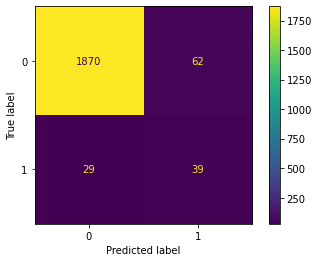

In [310]:
hf.evaluate(y_test, y_hats)

Given the recall a more important metrics, we choise the cutoff of 0.15 (rather than 0.2). The bare-bone Logistic Regression achieves Recall of **57%**, and the precision of **38%**. 

### Hyperparameter Tuning

In [262]:
from sklearn.model_selection import GridSearchCV